In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pylab as plt
from datetime import timedelta
import os
from matplotlib.widgets import Slider, Button
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import *
from sklearn import metrics
import itertools as it
import re


# To display more rows if required
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


#constants
csv_headers = ['timestamp','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
data_headers = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']

fall_scene_tags_headers = ['filename','scene','event']

fall_directory = './fall_data/'
non_fall_directory = './non_fall_data/'

In [2]:
#functions to analize dataframe

def prepare_df(df ,window_size, init_zones , fall_zones , reference_zone):
    for cell in data_headers:
        df[f'{cell}d'] = df[cell] - df[cell].shift(window_size)
    
    for cell in data_headers:
        df[f'{cell}dt'] = 0
        for ci in range(1, window_size + 1):
            df[f'{cell}dt'] += df[cell] - df[cell].shift(ci)
        df[f'{cell}dt'] /= window_size

    iz = 0;
    for zone in init_zones:
        colname = f'iza{iz}'
        df[colname] = df[zone].mean(axis=1)
        iz = iz + 1
    
    iz = 0;
    for zone in fall_zones:
        colname = f'fza{iz}'
        df[colname] = df[zone].mean(axis=1)
        iz = iz + 1
        
    iz = 0;
    for zone in init_zones:
        colname = f'izda{iz}'
        zone_d = [f'{z}d' for z in zone]
        df[colname] = df[zone_d].mean(axis=1)
        iz = iz + 1
    
    iz = 0;
    for zone in fall_zones:
        colname = f'fzda{iz}'
        zone_d = [f'{z}d' for z in zone]
        df[colname] = df[zone_d].mean(axis=1)
        iz = iz + 1
    
    df['rza'] = df[reference_zone].mean(axis=1)
    zone_d = [f'{z}d' for z in reference_zone]
    df['rzda'] = df[zone_d].mean(axis=1)
    
    #for cell in data_headers:
        #del df[f'{cell}d']

def analize_df(df ,window_size , init_zones , fall_zones , reference_zone , heatTransferThreshold = 0.2, heatAverageThreshold = 1.0 ,deltaThreshold = 0.4, clean = False , remove_temps = False):
    prepare_df(df, window_size , init_zones ,fall_zones , reference_zone )
    i = 0
    f = 0
    any_col = []
    for iz in init_zones:
        f = 0
        for fz in fall_zones:
            newcolname = f'iz{i}xfz{f}'
            htname = f'ht{i}x{f}'
            iza , izda , fza , fzda , rza , rzda = df[f'iza{i}'] , df[f'izda{i}'],df[f'fza{f}'] , df[f'fzda{f}'] , df['rza'] , df['rzda'] 
            
            test1 = (iza < (rza + heatAverageThreshold )) & ((rza + heatAverageThreshold ) < fza)
            test2 = (izda <= -deltaThreshold ) & (deltaThreshold <= fzda)
            
            heatTransferPerc = izda / fzda
            
            test3 = heatTransferPerc < 0
            
            heatTransferPerc = heatTransferPerc.abs()
            df[htname] = heatTransferPerc
            test4 = ((1 - heatTransferThreshold) <= heatTransferPerc) & (heatTransferPerc <= (1 + heatTransferThreshold ))
            
            new_serie =  test1 & test2 & test3 & test4
            any_col.append(new_serie)
            df[newcolname] = new_serie
            f = f + 1
        i = i + 1
    df['any'] = False
    for serie in any_col:
        df['any'] |= serie
    
    if clean:
        i = 0
        f = 0
        for cell in data_headers:
            del df[f'{cell}d']
            del df[f'{cell}dt']
        for iz in init_zones:
            del df[f'iza{i}']
            del df[f'izda{i}']
            i = i + 1;
        for fz in fall_zones:
            del df[f'fza{f}']
            del df[f'fzda{f}']
            f = f + 1;
        del df['rza']
        del df['rzda']
    
    return

In [10]:
# Functions to read files

# Get a dataframe from a csv
def get_dataframe(filename: str ) -> pd.DataFrame:
    input_data = pd.read_csv(filename, sep=',' , names= csv_headers)
    input_data['timestamp']= pd.to_datetime(input_data['timestamp'])
    return input_data

# Get the tags for the filenames
def get_tags_dataframe():
    input_data = pd.read_csv('fall_scene_tag.csv', sep=',' , names= fall_scene_tags_headers)
    input_data = input_data.set_index('filename')
    return input_data

# Get the main info for a file
def file_info(df : pd.DataFrame)->():
    row_count = df.shape[0]
    total_time = df['timestamp'].max() - df['timestamp'].min()
    avg_delta = total_time / row_count
    fps = timedelta(seconds = 1) /avg_delta
    return row_count , total_time , avg_delta, fps

def header_rename(name :str ) ->str:
    out = ''
    out = out + ('Final ' if 'f' in name else 'Init ' if 'i' in name else 'Reference ')
    out = out + ('Zone ')
    reg = re.search('\d',name)
    out = out + ('' if reg is None else reg.group()[0])
    # out = out + (' Delta Avg ' if 'd' in name else ' Average ')
    return out

In [4]:
# Load tags to identify the scene of the file and the event
tags_df = get_tags_dataframe()

In [115]:
# Algorithm parameters
Window_size = 14
HeatTransferThreshold = 0.1
HeatAverageThreshold = 1.0
DeltaThreshold = 0.3
Clean = False
Remove_temps = True
Scene_Number = 0
scenes = [
    #lateral fall #0
    {
        'name' : 'lateral scene detection',
        'init_z' : [
            ['1','5','9' ],
            ['2','6','10'],
            ['3','7','11'],
            ['4','8','12']
            ],

        'fall_z' : [
            ['13','14','15','16']
            ],
        'ref_z' : data_headers,
    },
    #frontal fall #1
    {
        'name': 'frontal scene detection',
        'init_z' : [
            ['6' , '10' ],
            ['7' , '11' ],
            ],

        'fall_z' : [
            ['14'],
            ['15']
            ],
        'ref_z' : data_headers,
    },
    #diagonal fall right -> left   #2
    {
        'name':'diagonal scene detection',
        'init_z' : [
            ['3' , '6', '7', '8','11' ],
            ],

        'fall_z' : [
            ['6', '9', '10','11' , '14'],
            ],
        'ref_z' : data_headers,
    },
    #diagonal fall left -> right   #3
    {
        'name':'diagonal2 scene detection',
        'init_z' : [
            ['5' , '6', '9', '10' ],
            ],
        'fall_z' : [
            ['11' , '12' , '15' , '16'],
            ],
        'ref_z' : data_headers,
                
    },
]

In [116]:
# SELECT DIRECTORY
cur_dir = fall_directory
#cur_dir = non_fall_directory

# SELECT FILE
cur_file = 'f_72.csv'
#cur_file = 'nf_201.csv'

cur_df = get_dataframe(cur_dir + cur_file)
r_cnt , t_time , a_dta , fps = file_info(cur_df)

evt = tags_df.loc[cur_file, 'event']
real_scene = tags_df.loc[cur_file, 'scene']

scene = scenes[Scene_Number]

analize_df(cur_df , Window_size , scene['init_z'] , scene['fall_z'] , scene['ref_z'], HeatTransferThreshold, HeatAverageThreshold,DeltaThreshold, Clean,Remove_temps)
cur_df = cur_df.replace([np.inf,-np.inf],0)

print('FILE LOADED')
print('valid file:\t', cur_dir + cur_file)
print('event:\t', evt.upper())
print('scene:\t', real_scene.upper())
print('rows:\t', r_cnt)
print('total time:\t' , str(t_time))
print('average delta:\t' , a_dta)
print('fps:\t', fps)


FILE LOADED
valid file:	 ./fall_data/f_72.csv
event:	 FALL
scene:	 NORMAL FALL SCENE
rows:	 37
total time:	 0 days 00:00:03.644000
average delta:	 0 days 00:00:00.098486486
fps:	 10.15367732787217


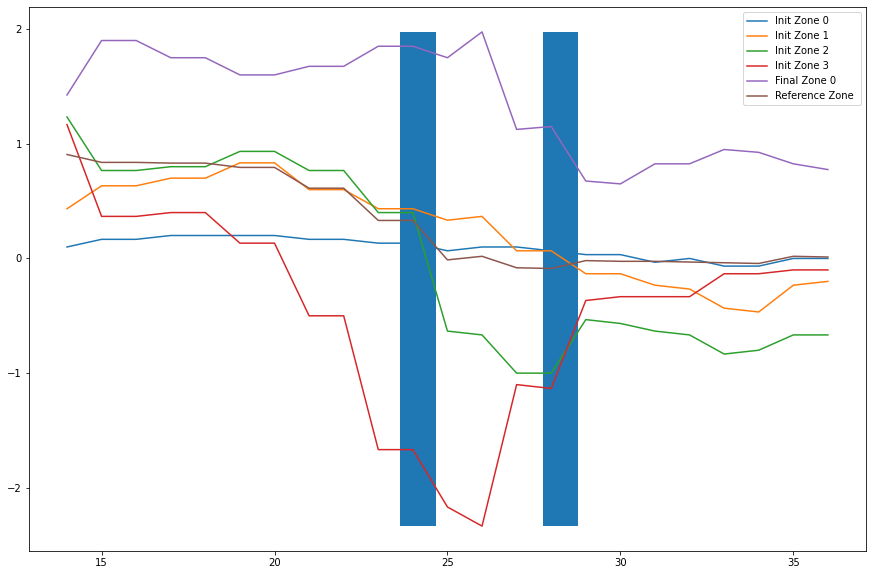

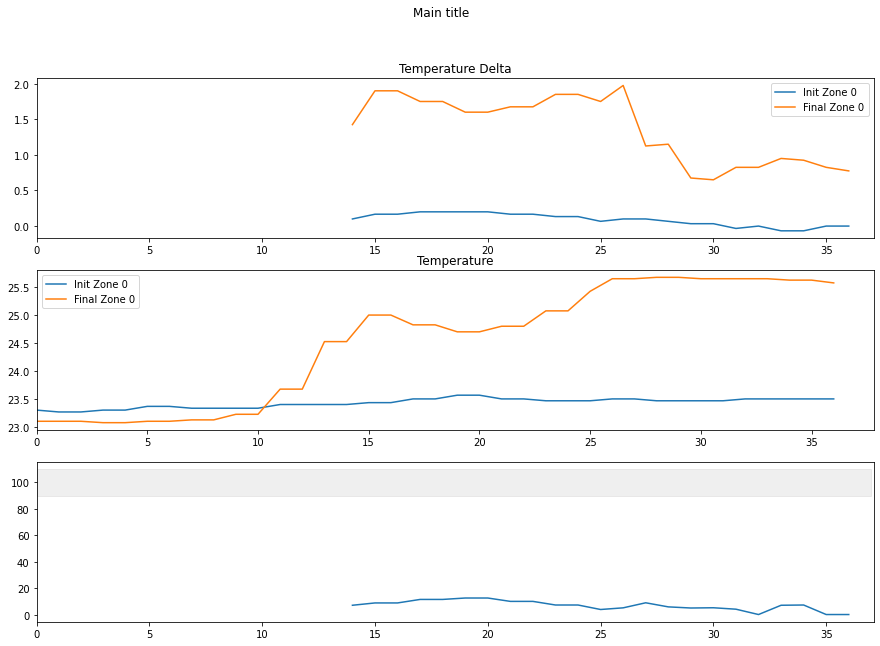

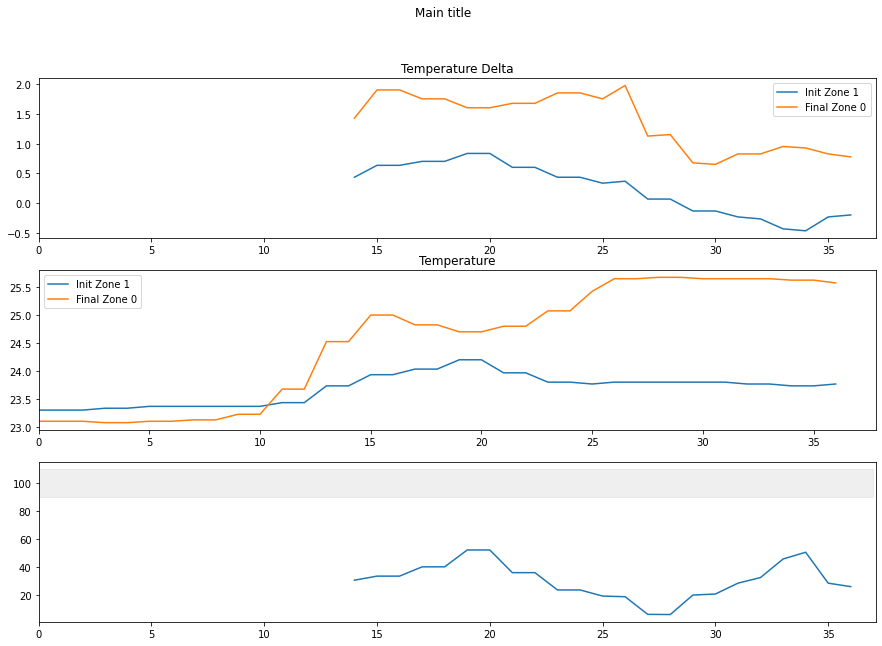

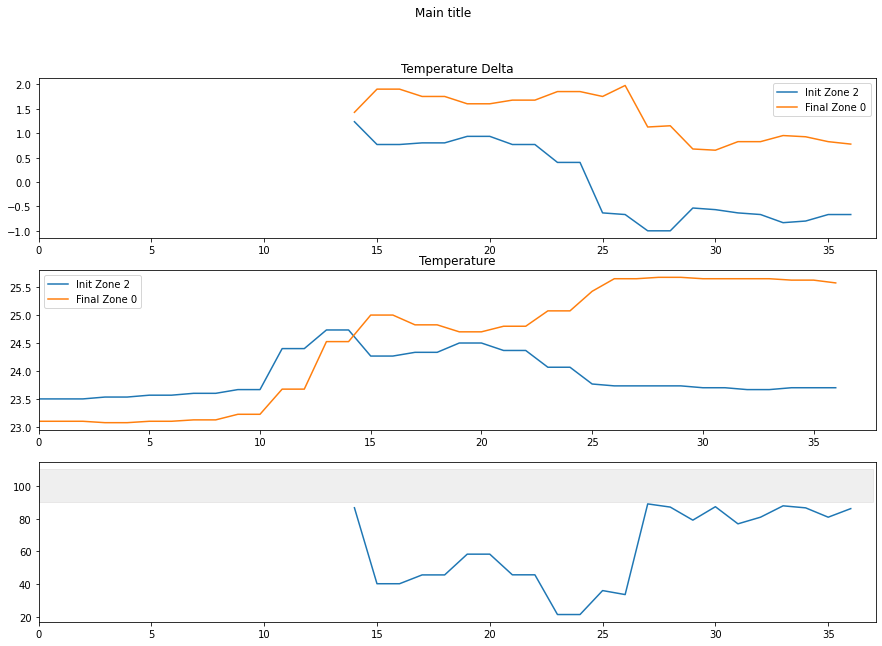

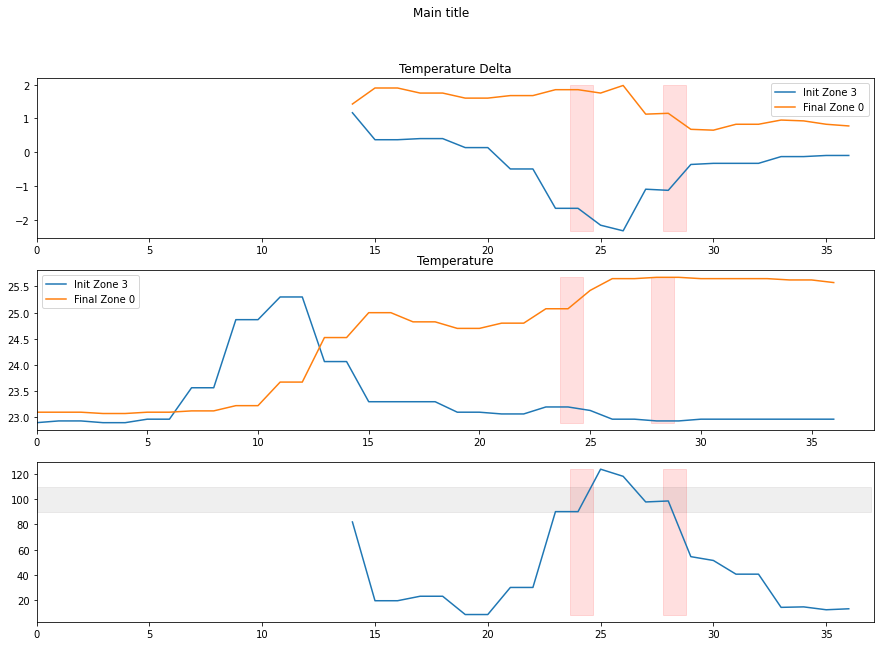

In [117]:
FIG = (15, 10)
FALL_COLOR = '#ff000020'
RANGE_COLOR = '#0F000010'


# All Zone plot
izr = range(0,len(scene['init_z']))
fzr = range(0,len(scene['fall_z']))

all_zones = it.chain(izr,fzr)

# PLOT TEMPERATURES
all_avgs = [x for x in it.chain( [f'izda{i}' for i in izr] ,  [f'fzda{f}' for f in fzr] ,['rzda'] )]

fdf = cur_df['any']

pdf = cur_df[all_avgs]

ax = pdf.plot(figsize = FIG)
pmin = pdf.min().min()
pmax = pdf.max().max()
x = np.linspace(0,len(pdf),len(pdf))
ax.fill_between(x, pmin, pmax, where=fdf)

names = [header_rename(h) for h in all_avgs]
ax.legend(names)


tups = [i for i in it.product( izr , fzr )]

for tup in tups:
    title_name = f'Interactions between Init Zone {tup[0]} and  Final Zone {tup[1]}'
    figure , (ax1 , ax2 , ax3) = plt.subplots(nrows=3,ncols=1 , figsize = FIG)
    figure.suptitle('Main title')
    delta_cols = [f'izda{tup[0]}',f'fzda{tup[1]}']
    temp_cols = [f'iza{tup[0]}',f'fza{tup[1]}']
    transf_col = f'ht{tup[0]}x{tup[1]}'
    fall_col = f'iz{tup[0]}xfz{tup[1]}'
    
    delta_df = cur_df[delta_cols]
    temp_df = cur_df[temp_cols]
    transf_df = cur_df[transf_col] * 100
    fall_df = cur_df[fall_col]
    
    
    pmin = pdf.min().min()
    pmax = pdf.max().max()
    pdif = pmax-pmin
        
    
    
    for df, axx , cols, title in [ (temp_df , ax2 , temp_cols , "Temperature") , (delta_df, ax1 ,delta_cols,"Temperature Delta") , ] :
        df.plot(ax = axx )
        axx.legend([header_rename(h) for h in cols])   
        axx.set_title(title)
        x = np.linspace(0,len(pdf),len(pdf))
        pmin = df.min().min()
        pmax = df.max().max()
        axx.fill_between(x, pmin, pmax, where=fall_df, color=FALL_COLOR)
        axx.set_xlim(0)
    
    pmin = transf_df.min()
    pmax = transf_df.max()
    
    transf_df.plot(ax=ax3)
    ax3.set_xlim(0)
    ax3.fill_between(x, pmin, pmax, where=fall_df, color=FALL_COLOR)
    ax3.fill_between(x, (1-HeatTransferThreshold) * 100 , (1+HeatTransferThreshold) * 100 , color=RANGE_COLOR)
        